In [1]:
# importing libraries

#
import os

# numerical and data manipulation libraries
import numpy as np
import pandas as pd

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#
from sklearn.model_selection import train_test_split

# evaluation metrics and class balancing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#
import cv2

# deep learning frameworks
import keras
import tensorflow as tf

# image preprocessing tools
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import save_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

# model architecture and training utilities
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!pip install kaggle
from google.colab import files
files.upload()  # এখানে kaggle.json upload করুন
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d maedemaftouni/covid19-ct-scan-lesion-segmentation-dataset
!unzip -q covid19-ct-scan-lesion-segmentation-dataset.zip -d covid19_ct_lesion


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/maedemaftouni/covid19-ct-scan-lesion-segmentation-dataset
License(s): other
 97% 668M/688M [00:03<00:00, 223MB/s]
100% 688M/688M [00:03<00:00, 219MB/s]


In [3]:
# Define the path to the extracted dataset
data_dir = '/content/covid19_ct_lesion'

# Get a list of all image files in the dataset directory
all_files = []
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'): # Add other image extensions if needed
            all_files.append(os.path.join(root, file))

print(f"Total number of files found: {len(all_files)}")

Total number of files found: 5458


In [4]:
# Split files into train, validation, and test sets
train_files, test_files = train_test_split(all_files, test_size=0.15, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.15, random_state=42)

print(f"Train: {len(train_files)}, Validation: {len(val_files)}, Test: {len(test_files)}")

Train: 3943, Validation: 696, Test: 819


In [5]:
BATCH_SIZE = 8     # or whatever batch size you want
IMG_SIZE = 256

In [6]:
# Data generator for CT image segmentation (inherits from Keras Sequence)
class CTDataGen(Sequence):
    def __init__(self, file_list, img_dir, mask_dir, batch_size=BATCH_SIZE, img_size=IMG_SIZE):
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size

    # Returns the number of batches per epoch
    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    # Loads and returns a batch of images and masks
    def __getitem__(self, idx):
        batch_files = self.file_list[idx*self.batch_size:(idx+1)*self.batch_size]
        imgs, masks = [], []
        for fname in batch_files:
            img = cv2.imread(os.path.join(self.img_dir, fname), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img / 255.0
            imgs.append(np.expand_dims(img, axis=-1))
            mask = cv2.imread(os.path.join(self.mask_dir, fname), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.img_size, self.img_size))
            mask = (mask > 127).astype(np.float32)  # Binarize mask
            masks.append(np.expand_dims(mask, axis=-1))
        return np.array(imgs), np.array(masks)

Part 4 - Architecture Network Neural Convolutional MCANet


In [7]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, Multiply

def channel_attention(x, ratio=8):
    channels = x.shape[-1]
    avg_pool = GlobalAveragePooling2D()(x)  # Global context
    fc1 = Dense(channels // ratio, activation='relu')(avg_pool)
    fc2 = Dense(channels, activation='sigmoid')(fc1)
    scale = Reshape((1, 1, channels))(fc2)
    return Multiply()([x, scale])


Step 2: Multi-scale Convolution Block (MCB)

In [8]:
from tensorflow.keras.layers import Conv2D, concatenate

def multi_scale_conv(x, filters):
    c1 = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
    c2 = Conv2D(filters, (5,5), padding='same', activation='relu')(x)
    c3 = Conv2D(filters, (7,7), padding='same', activation='relu')(x)
    out = concatenate([c1, c2, c3])
    return out


U-Net + MCB + Channel Attention → MCANet

In [9]:
def build_mcanet(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = multi_scale_conv(inputs, 16)
    c1 = channel_attention(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = multi_scale_conv(p1, 32)
    c2 = channel_attention(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = multi_scale_conv(p2, 64)
    c3 = channel_attention(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = multi_scale_conv(p3, 128)
    c4 = channel_attention(c4)
    p4 = MaxPooling2D((2,2))(c4)

    # Bottleneck
    c5 = multi_scale_conv(p4, 256)
    c5 = channel_attention(c5)

    # Decoder
    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = multi_scale_conv(u6, 128)
    c6 = channel_attention(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = multi_scale_conv(u7, 64)
    c7 = channel_attention(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = multi_scale_conv(u8, 32)
    c8 = channel_attention(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = multi_scale_conv(u9, 16)
    c9 = channel_attention(c9)

    # Output layer
    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model


In [10]:
# Paths to your images and masks
IMG_DIR = "/content/unetr_model/unetr/images"
MASK_DIR = "/content/unetr_model/unetr/masks"

# Parameters
BATCH_SIZE = 8
IMG_SIZE = 256

In [11]:
# Generator for the training set
train_gen = CTDataGen(train_files, IMG_DIR, MASK_DIR, BATCH_SIZE, IMG_SIZE)

# Generator for the validation set
val_gen = CTDataGen(val_files, IMG_DIR, MASK_DIR, BATCH_SIZE, IMG_SIZE)

# Generator for the test set
test_gen = CTDataGen(test_files, IMG_DIR, MASK_DIR, BATCH_SIZE, IMG_SIZE)

In [12]:
# Build, compile and print summary
model = build_mcanet((IMG_SIZE, IMG_SIZE, 1))

# Recommended loss/metrics for binary segmentation: binary_crossentropy + Dice can help.
# Here I include binary_crossentropy and accuracy like you had; you can add Dice later.
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │        416 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │        800 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 48)        │          0 │ concatenate[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 6)         │        294 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 48)        │        336 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 48)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 256,  │          0 │ concatenate[0][0… │
│                     │ 48)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     13,856 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     38,432 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     75,296 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 96)               │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 96)        │          0 │ concatenate_1[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 12)        │      1,164 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 18,834,725 (71.85 MB)

 Trainable params: 18,834,725 (71.85 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# 3. Train the model
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=5)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
493/493 ━━━━━━━━━━━━━━━━━━━━ 387s 638ms/step - accuracy: 0.9623 - loss: 0.1306 - val_accuracy: 0.9969 - val_loss: 0.0081
Epoch 2/5
493/493 ━━━━━━━━━━━━━━━━━━━━ 250s 507ms/step - accuracy: 0.9955 - loss: 0.0175 - val_accuracy: 0.9974 - val_loss: 0.0068
Epoch 3/5
493/493 ━━━━━━━━━━━━━━━━━━━━ 257s 522ms/step - accuracy: 0.9977 - loss: 0.0063 - val_accuracy: 0.9979 - val_loss: 0.0053
Epoch 4/5
493/493 ━━━━━━━━━━━━━━━━━━━━ 249s 505ms/step - accuracy: 0.9971 - loss: 0.0087 - val_accuracy: 0.9977 - val_loss: 0.0056
Epoch 5/5
493/493 ━━━━━━━━━━━━━━━━━━━━ 249s 504ms/step - accuracy: 0.9983 - loss: 0.0050 - val_accuracy: 0.9982 - val_loss: 0.0047


Part 6 - Metrics and evaluation

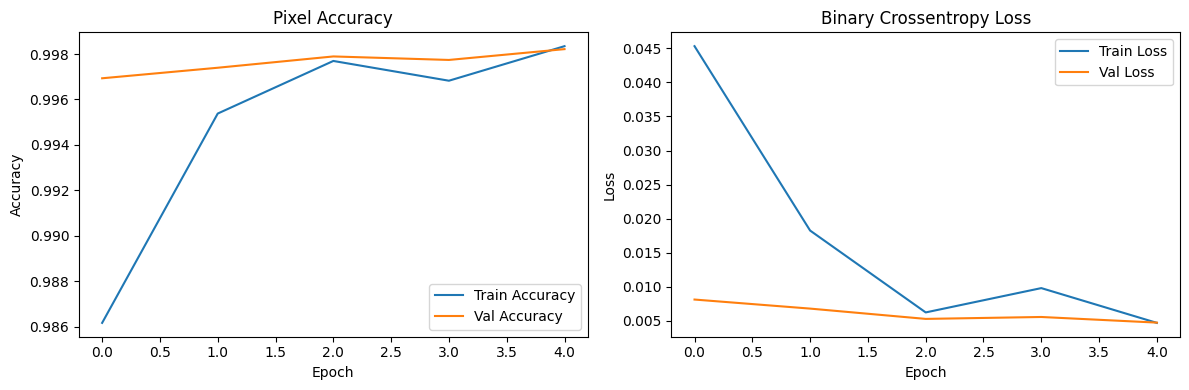

In [14]:
plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Pixel Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Binary Crossentropy Loss')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


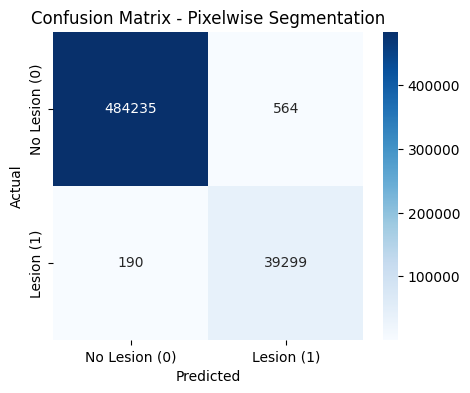

In [15]:
# Get a batch from the test_gen
imgs, masks_true = test_gen[0]
masks_pred = model.predict(imgs)

# Flatten the masks (pixel by pixel)
all_true = []
all_pred = []
for i in range(masks_true.shape[0]):
    true_mask = masks_true[i][:,:,0].astype(np.uint8).flatten()
    pred_mask = (masks_pred[i][:,:,0] > 0.5).astype(np.uint8).flatten()
    all_true.extend(true_mask)
    all_pred.extend(pred_mask)

# Confusion matrix
cm = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Lesion (0)', 'Lesion (1)'],
            yticklabels=['No Lesion (0)', 'Lesion (1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Pixelwise Segmentation")
plt.show()

In [16]:
# Classification report
target_names = ['No Lesion (0)', 'Lesion (1)']
print(classification_report(all_true, all_pred, target_names=target_names, digits=4))

               precision    recall  f1-score   support

No Lesion (0)     0.9996    0.9988    0.9992    484799
   Lesion (1)     0.9859    0.9952    0.9905     39489

     accuracy                         0.9986    524288
    macro avg     0.9927    0.9970    0.9949    524288
 weighted avg     0.9986    0.9986    0.9986    524288



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


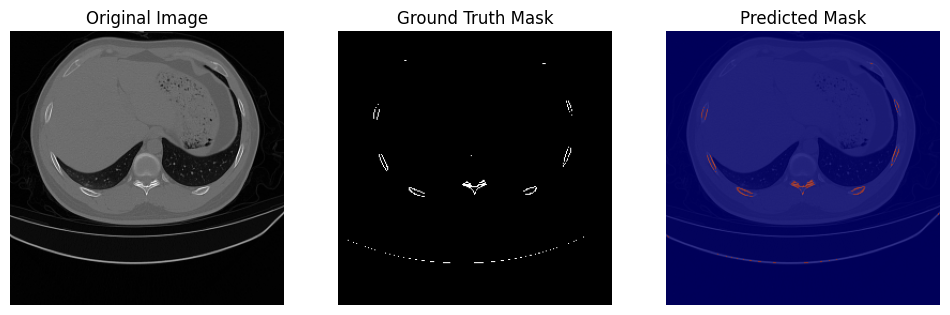

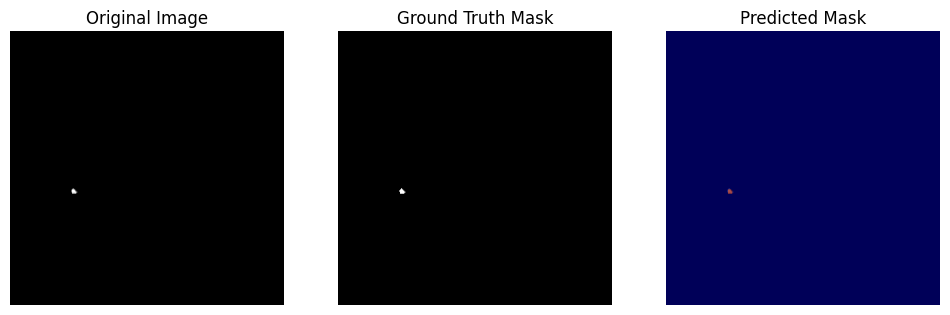

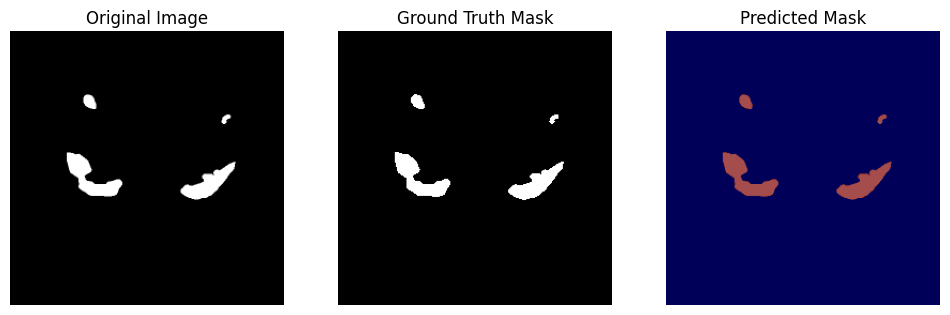

In [23]:
# Get a batch from the test set
imgs, true_masks = test_gen[2]
pred_masks = model.predict(imgs)

for i in range(3):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(imgs[i][:,:,0], cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(true_masks[i][:,:,0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(imgs[i][:,:,0], cmap='gray')
    plt.imshow(pred_masks[i][:,:,0] > 0.5, cmap='jet', alpha=0.7)
    plt.title("Predicted Mask")
    plt.axis('off')
    plt.show()

In [20]:
# Saving Neural Network Model - MCANet 1
model.save('mcanet_1_segmentacao.h5')


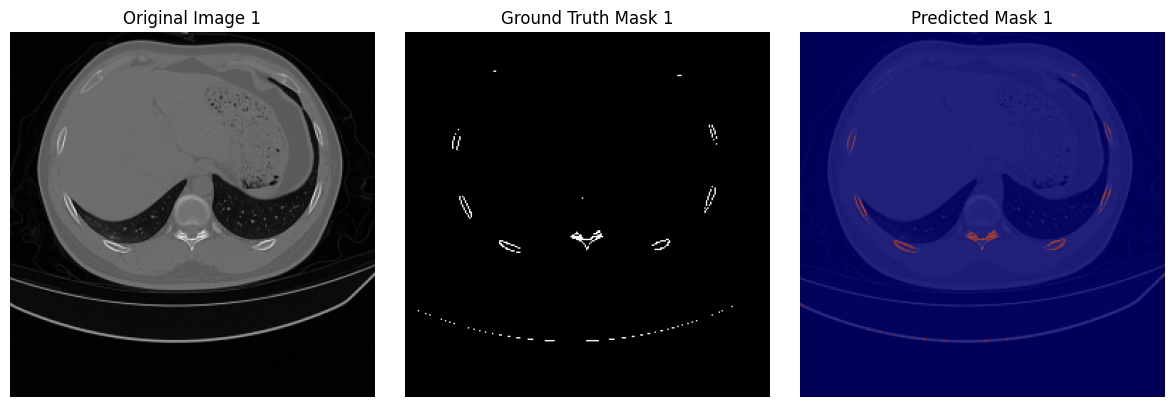

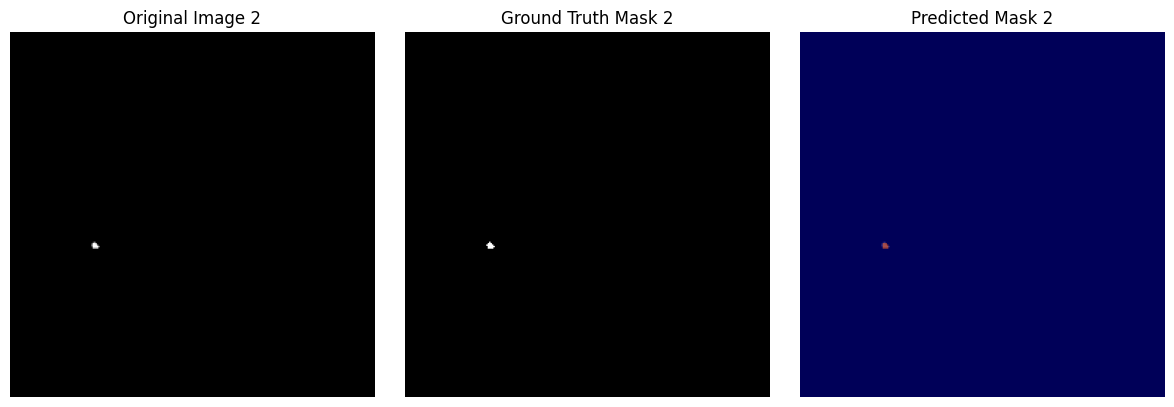

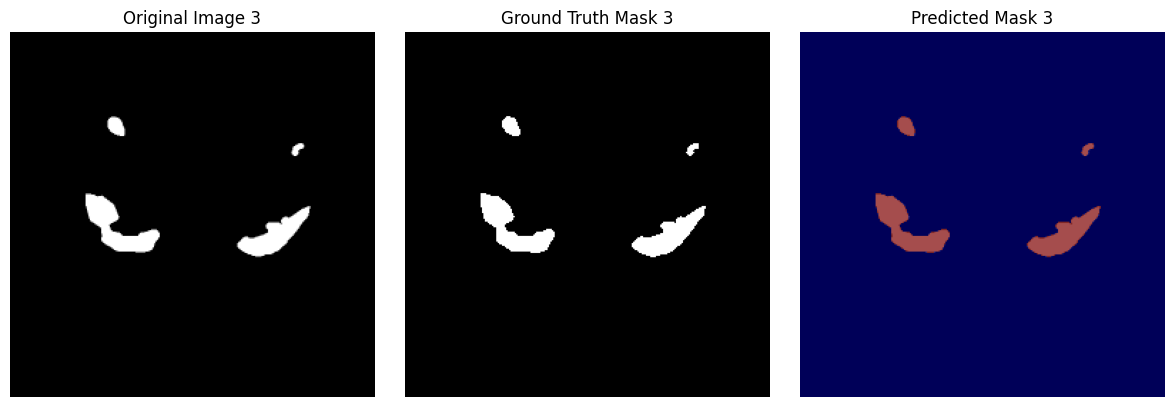

In [26]:
import matplotlib.pyplot as plt

# Check how many samples are in the batch
num_samples = min(3, len(imgs))

for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(imgs[i][:, :, 0], cmap='gray')
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_masks[i][:, :, 0], cmap='gray')
    plt.title(f"Ground Truth Mask {i+1}")
    plt.axis('off')

    # Predicted Mask Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(imgs[i][:, :, 0], cmap='gray')
    plt.imshow(pred_masks[i][:, :, 0] > 0.5, cmap='jet', alpha=0.7)
    plt.title(f"Predicted Mask {i+1}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [28]:
import cv2
from tensorflow.keras.models import load_model

# If you did not use custom metrics:
model_pred = load_model('/content/mcanet_1_segmentacao.h5')

In [29]:
frames_dir = '/content/covid19_ct_lesion/frames' # Corrected path
img_filename = 'Jun_coronacases_case10_118.png'  # or any filename from the list
img_path = os.path.join(frames_dir, img_filename)

In [30]:
# Load the image in grayscale
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Resize to (256, 256)
img = cv2.resize(img, (256, 256))

# Normalize pixel values to [0, 1]
img = img / 255.0

# Add batch and channel dimensions: (1, 256, 256, 1)
img_input = np.expand_dims(img, axis=(0, -1))

In [31]:
# Make prediction
mask_pred = model_pred.predict(img_input)[0, :, :, 0]
mask_pred_bin = (mask_pred > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


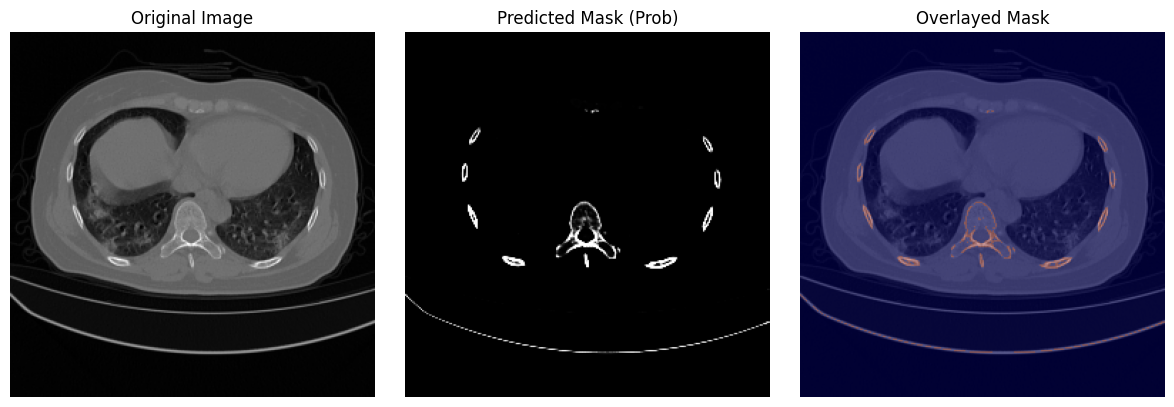

In [32]:
  # Visualization
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask_pred, cmap='gray')
plt.title('Predicted Mask (Prob)')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img, cmap='gray')
plt.imshow(mask_pred_bin, cmap='jet', alpha=0.4)
plt.title('Overlayed Mask')
plt.axis('off')
plt.tight_layout()
plt.show()

In [33]:
# Load the corresponding ground truth mask
mask_path = os.path.join('/content/covid19_ct_lesion/masks', img_filename)

In [34]:
mask_true = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask_true = cv2.resize(mask_true, (256, 256))
mask_true_bin = (mask_true > 127).astype(np.uint8)

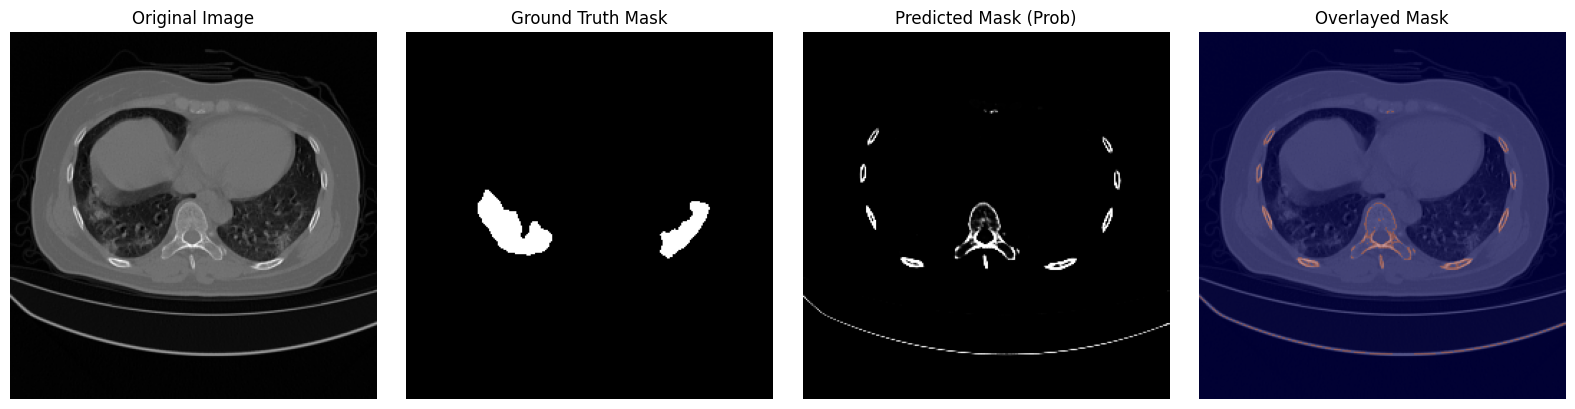

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 24s 235ms/step - accuracy: 0.9983 - loss: 0.0046
Accuracy reported by Keras: 0.9984
Pixel-wise accuracy (image): 0.9610


In [35]:
# Plot side by side
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(mask_true_bin, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(mask_pred, cmap='gray')
plt.title('Predicted Mask (Prob)')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(img, cmap='gray')
plt.imshow(mask_pred_bin, cmap='jet', alpha=0.4)
plt.title('Overlayed Mask')
plt.axis('off')
plt.tight_layout()
plt.show()

results = model.evaluate(test_gen, verbose=1)
# results[1] is the accuracy if you compiled with metrics=['accuracy']
print(f"Accuracy reported by Keras: {results[1]:.4f}")

accuracy_pixel = np.mean(mask_true_bin == mask_pred_bin)
print(f"Pixel-wise accuracy (image): {accuracy_pixel:.4f}")